In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets list -s leapgestrecog

ref                                        title                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------  ---------------------------------  ----  -------------------  -------------  ---------  ---------------  
gti-upm/leapgestrecog                      Hand Gesture Recognition Database   2GB  2018-07-30 06:43:29          18650        543  0.75             
maychondouglas/hands-gestures-augmentated  Hands Gestures Augmentated          6GB  2020-06-18 04:22:24              7          1  0.125            
maychondouglas/novoleapgestrecog           NOVOleapGestRecog                   2GB  2020-06-19 00:00:00              4          0  0.1875           


In [4]:
! kaggle datasets download gti-upm/leapgestrecog

 99% 2.11G/2.13G [00:23<00:00, 128MB/s]
100% 2.13G/2.13G [00:23<00:00, 96.7MB/s]


In [5]:
! mkdir dataset

In [6]:
! unzip leapgestrecog.zip -d dataset

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: dataset/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: dataset/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: dataset/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: dataset/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: dataset/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: dataset/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: dataset/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: dataset/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: dataset/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: dataset/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: dataset/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflat

In [7]:
! rm -R leapgestrecog.zip

In [8]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 11.5 MB/s eta 0:00:00


In [89]:
import time
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import mediapipe as mp
import os
import torch
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tt
from torchvision import models
import torch.nn as nn

In [10]:
mp_face_detection = mp.solutions.face_detection
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

In [11]:
face_detection = mp_face_detection.FaceDetection()
hand_tracking = mp_hands.Hands()

In [64]:
def face_then_hand(image):

  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # поиск лица
  face_results = face_detection.process(image_rgb)
  if face_results.detections:
    print('Face detected!')
    for detection in face_results.detections:
      bbox = detection.location_data.relative_bounding_box
      h, w, c = image.shape
      x_f, y_f, width_f, height_f = int(bbox.xmin * w), int(bbox.ymin * h), int(bbox.width * w), int(bbox.height * h)

      # отрисовка лица
    cv2.rectangle(image, (x_f, y_f), (x_f + width_f, y_f + height_f), (0, 255, 0), 2)
    # поиск рук
    hand_results = hand_tracking.process(image_rgb)
    if hand_results.multi_hand_landmarks:
      for hand_landmarks in hand_results.multi_hand_landmarks:
        x_h = []
        y_h = []
        pad = 75
        for i in range(21):
          x_h.append(hand_landmarks.landmark[i].x)
          y_h.append(hand_landmarks.landmark[i].y)
        x_h, y_h, x_h2, y_h2 = int(min(x_h) * w - pad), int(min(y_h) * h - pad), int(max(x_h) * w + pad), int(max(y_h) * h + pad)
        crop_img = image[y_h+2:y_h2-2, x_h+2:x_h2-2]
        cv2.rectangle(image, (x_h, y_h), (x_h2, y_h2), (0, 0, 255), 2) #отрисовка руки или рук

  return image, crop_img

In [86]:
image = files.upload()

Saving WIN_20230803_02_12_21_Pro.jpg to WIN_20230803_02_12_21_Pro.jpg


In [69]:
image = cv2.imread('/content/WIN_20230803_01_54_40_Pro.jpg')

In [70]:
%time
processed_image, hand = face_then_hand(image)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Face detected!


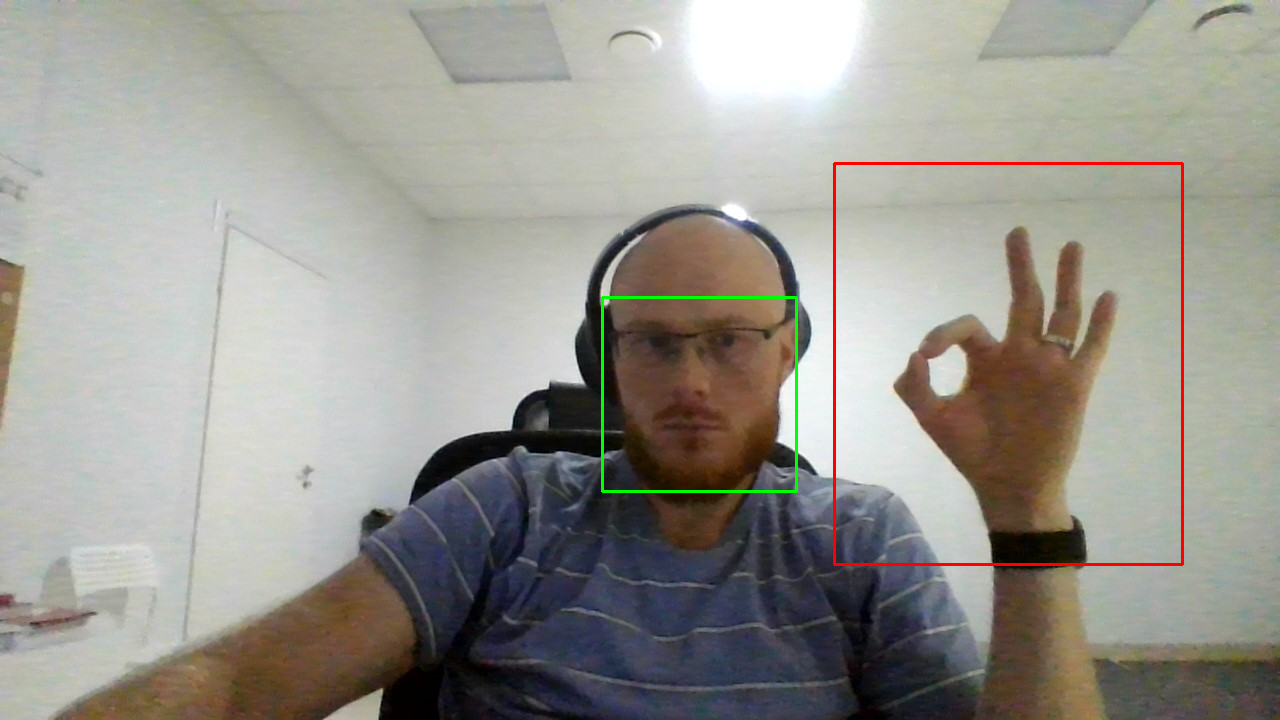

In [71]:
cv2_imshow(processed_image)

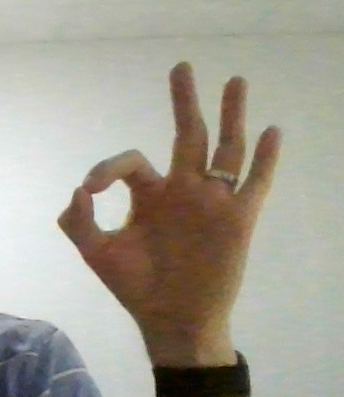

In [72]:
cv2_imshow(hand)

In [18]:
data_path = '/content/dataset/leapGestRecog/'

In [19]:
data_dict = {'img_path' : [], 'target': []}
for path in os.listdir(data_path):
  for target_name in os.listdir(data_path + path):
    for img_name in os.listdir(data_path + path + '/' + target_name):
      data_dict['target'].append(target_name)
      whole_img_path = data_path + path + '/' + target_name + '/' + img_name
      data_dict['img_path'].append(whole_img_path)

In [20]:
df = pd.DataFrame(data_dict)

In [21]:
df.head(3)

,img_path,target
0,/content/dataset/leapGestRecog/01/02_l/frame_0...,02_l
1,/content/dataset/leapGestRecog/01/02_l/frame_0...,02_l
2,/content/dataset/leapGestRecog/01/02_l/frame_0...,02_l


In [22]:
df['target'].unique()

array(['02_l', '05_thumb', '04_fist_moved', '03_fist', '01_palm',
       '06_index', '08_palm_moved', '07_ok', '09_c', '10_down'],
      dtype=object)

In [23]:
target_replace_dict = {
    '06_index': 5,
    '03_fist': 2,
    '09_c': 8,
    '08_palm_moved': 7,
    '04_fist_moved': 3,
    '01_palm' : 0,
    '02_l' : 1,
    '10_down' : 9,
    '05_thumb' : 4,
    '07_ok' : 6
    }

In [24]:
df['target'].replace(target_replace_dict, inplace=True)

In [25]:
def digit_to_classname(digit):
  cls = list(target_replace_dict.keys())[list(target_replace_dict.values()).index(digit)]
  return cls

In [113]:
digit_to_classname(6)

'07_ok'

### К сети

In [114]:
train, test = train_test_split(df, test_size=0.3, random_state=42, shuffle=True)

In [115]:
len(test)

6000

In [116]:
class ClassificationDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df  = df.reset_index(drop=True)
    self.transform  = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    img_path = self.df['img_path'][index]
    target = self.df['target'][index]
    img = np.array(Image.open(img_path).convert("L"), dtype=np.float32)
    if self.transform is not None:
      img = self.transform(img)

    return img, target

In [117]:
train_tfms = tt.Compose([tt.ToPILImage(),
                         tt.Resize((128, 128)),
                         tt.Grayscale(num_output_channels=1), # Картинки черно-белые
                         # Настройки для расширения датасета
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.ToTensor()])                      # Приведение к тензору

test_tfms = tt.Compose([tt.ToPILImage(), tt.Resize((128, 128)), tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [118]:
train_ds = ClassificationDataset(train, transform=train_tfms)

In [119]:
test_ds = ClassificationDataset(test, transform=test_tfms)

In [120]:
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader   = DataLoader(test_ds, batch_size=128, shuffle=True)

### Проверка что все работает

07_ok


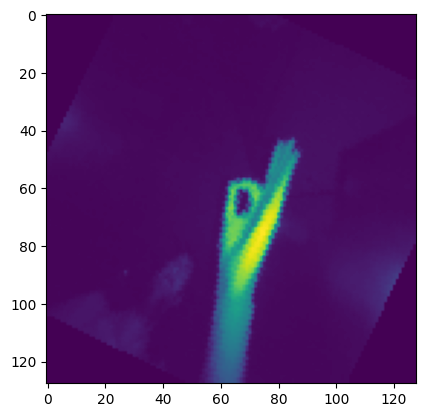

In [141]:
inputs, targets = next(iter(train_loader))
plt.imshow(inputs[0].permute(1,2,0))
print(digit_to_classname(targets[0]))

### Модель

In [148]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = models.resnet18(pretrained=True)
# Convert model to grayscale
net.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Update the fully connected layer based on the number of classes in the dataset
net.fc = torch.nn.Linear(net.fc.in_features, 10)

net.to(device)

# Specity the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
def train_model(loader, test_loader, model, epochs = 1):
    for epoch in range(epochs):  # loop over the dataset multiple times

        # Zero the performance stats for each epoch
        running_loss = 0.0
        start_time = time.time()
        total = 0
        correct = 0

        for i, data in enumerate(loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data[0]
            labels = data[1]

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total

            # Print performance statistics
            running_loss += loss.item()
            if i % 10 == 0:    # print every 10 batches
                batch_time = time.time()
                speed = (i+1)/(batch_time-start_time)
                print('[%d, %5d] loss: %.3f, speed: %.2f, accuracy: %.2f %%' %
                      (epoch + 1, i, running_loss, speed, accuracy))

                running_loss = 0.0

        print('Testing Model Performance')
        test_model(test_loader, model)

    print('Finished Training')

In [37]:
def test_model(loader, model):
    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data[0]
            labels = data[1]

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total

        print('Finished Testing')
        print('Testing accuracy: %.1f %%' %(accuracy))

In [149]:
train_model(train_loader, test_loader, net, epochs = 5)

[1,     0] loss: 2.518, speed: 0.77, accuracy: 14.84 %
[1,    10] loss: 24.322, speed: 1.66, accuracy: 13.14 %
[1,    20] loss: 22.263, speed: 1.80, accuracy: 15.70 %
[1,    30] loss: 21.186, speed: 1.78, accuracy: 18.62 %
[1,    40] loss: 19.880, speed: 1.82, accuracy: 22.03 %
[1,    50] loss: 18.933, speed: 1.80, accuracy: 25.32 %
[1,    60] loss: 17.753, speed: 1.83, accuracy: 28.69 %
[1,    70] loss: 16.950, speed: 1.86, accuracy: 31.72 %
[1,    80] loss: 15.674, speed: 1.84, accuracy: 34.74 %
[1,    90] loss: 14.848, speed: 1.83, accuracy: 37.58 %
[1,   100] loss: 14.348, speed: 1.82, accuracy: 40.14 %
Testing Model Performance
Finished Testing
Testing accuracy: 74.5 %
[2,     0] loss: 1.258, speed: 1.39, accuracy: 75.00 %
[2,    10] loss: 12.542, speed: 1.93, accuracy: 71.88 %
[2,    20] loss: 11.976, speed: 1.86, accuracy: 72.10 %
[2,    30] loss: 11.225, speed: 1.67, accuracy: 73.21 %
[2,    40] loss: 10.276, speed: 1.75, accuracy: 74.73 %
[2,    50] loss: 10.021, speed: 1.75, 

In [73]:
hand = test_tfms(hand).to(device)

In [74]:
outputs = net(torch.unsqueeze(hand.float(), 1))
_, predicted = torch.max(outputs.data, 1)

In [75]:
digit_to_classname(predicted)

'07_ok'

In [82]:
font = cv2.FONT_HERSHEY_SIMPLEX
text = str(digit_to_classname(predicted))
org = (50, 50)
color = (255, 255, 0)
picture = cv2.putText(processed_image, text, org, font, 1, color, 2, cv2.LINE_AA)

In [151]:
def load_photo_and_predict_gesture(img_path, net):
  image = cv2.imread(img_path)
  processed_image, hand = face_then_hand(image)
  hand = test_tfms(hand).to(device)
  outputs = net(torch.unsqueeze(hand.float(), 1))
  _, predicted = torch.max(outputs.data, 1)
  picture = cv2.putText(processed_image, text, org, font, 1, color, 2, cv2.LINE_AA)
  cv2_imshow(picture)


Face detected!


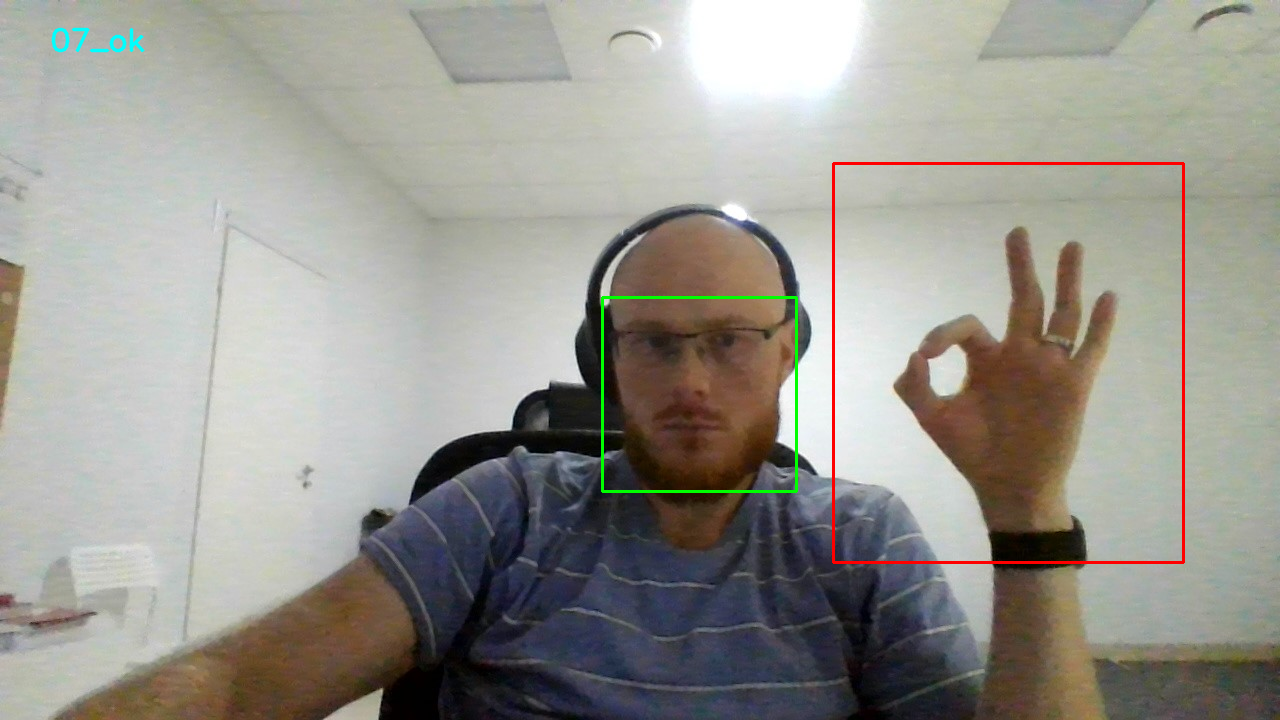

In [152]:
load_photo_and_predict_gesture('/content/WIN_20230803_01_54_40_Pro.jpg', net)